# BACKPROJECT IMAGE CLASSIFICATION RESULTS ONTO THE POINT CLOUD

In [1]:
from rdflib import Graph, URIRef
import os.path
import importlib
import numpy as np
import xml.etree.ElementTree as ET
import open3d as o3d
import uuid    
import pye57 
import ifcopenshell
import ifcopenshell.geom as geom
import ifcopenshell.util
from ifcopenshell.util.selector import Selector
import random as rd
import pandas as pd
import cv2
import laspy
import copy
from matplotlib import pyplot as plt
import math
import pathlib
import PIL
import PIL.Image
# import tensorflow as tf
# from tensorflow import keras
import random
#IMPORT MODULES
from context import geomapi 
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
from geomapi.tools import progresstools as pt
from geomapi.utils import imageutils as iu
from geomapi.tools import machinelearningtools as mlt

import geomapi.tools as tl

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

## USER INPUT

general

In [4]:
projectPath= os.path.join("D:\\Data\\2023-01 Paestum")
sessionPath = os.path.join(projectPath,"Research")

test1

In [228]:
#PCD
lasPath=os.path.join(projectPath,"PCD","dense_point_cloud_0.004.las")
outputlasPath=os.path.join(projectPath,"PCD","paestum_test1_out.las")
transform=np.array([[1.0,0.0, 0.0,  5.3857862609899980e+000], 
                [0.0, 1.0, 0.0, 2.5782303777102851e+002],
                [0.0, 0.0, 1.0 ,-6.0074548600459288e+000],
                [0.0 ,0.0, 0.0, 1.000000000000]]) # -> apply to pcd
scale=1/1.8781217664810130e+000 # -> apply to pcd

# -10
# +10
#  5.3857862609899980e+000
# 2.5782303777102851e+002 
#Images
xmlPath=os.path.join(projectPath,'IMG','cameras.xml')
sensorid=1
focalLength35mm= 2428.49184473261
rotation=np.array([[-9.9927572727173009e-001, -9.2989357887395263e-003 ,3.6899196180300041e-002,0],
                        [ 3.4752208827689118e-002, 1.7201294833769601e-001, 9.8448150291702796e-001,0],
                        [-1.5501769807091738e-002, 9.8505079838421061e-001 , -1.7156520549190035e-001,0],
                        [0,0,0,1]]) # -> apply to images
       
#classification
# modelMPath=os.path.join(sessionPath,"Facade_classification","Model_MobileNetV2__materials")
# modelTCPath=os.path.join(sessionPath,"Facade_classification","Model_MobileNetV2_BuildingTechniques")
# modelDPath=os.path.join(sessionPath,"Facade_classification","Model_MobileNetV2_Damages")
# trainingsfolder=pathlib.Path(os.path.join(sessionPath,'shapeConv','temp'))
# tf_image_folder=pathlib.Path(os.path.join(sessionPath,'Classification_test1','im_temp'))
# tf_mask_folder=pathlib.Path(os.path.join(sessionPath,'Classification_test1','mask_temp'))
output_dir=os.path.join(sessionPath,'shapeConv')
dir_img=os.path.join(output_dir,'image') # already full
dir_class=os.path.join(output_dir,'class') # already full
dir_depth=os.path.join(output_dir,'depth') #already full
dir_hha=os.path.join(output_dir,'hha') 
dir_labels=os.path.join(output_dir,'label12')

# tempfolder=pathlib.Path(os.path.join(sessionPath,'Facade_classification','temp'))
# batch_size = 32 #! same as model
# class_names_m=[0.0,1.0]
# class_names_tc=[0.0,1.0,2.0]
# class_names_d=[1.0,2.0]
# imagePath=os.path.join(projectPath,'Research')
# filteringWeight=3
# colors=[(255,0,0),(0,255,0),(0,0,255)]
# pixelRange=224
# rayOffsetDistance=0.2
skip=300 #nth file tu use


## PREPROCESS POINT CLOUD

Create point cloud node with proper offset.

In [246]:
lasPath='K:/Projects/2024-10 Project FWO Postdoc MB/7.Data/2024-01 Heritage Wall/PCD/Dataset_II_Pecile_wall_0.005m.las'
xmlPath='K:/Projects/2024-10 Project FWO Postdoc MB/7.Data/2024-01 Heritage Wall/IMG_undistorted/cameras.xml'

In [247]:
las  = laspy.read(lasPath)
pcdNode=PointCloudNode(name=ut.get_filename(lasPath),
                        lasPath=lasPath,
                        resource=gmu.las_to_pcd(las)
                        )

## PREPROCESS THE IMAGES WITH THE POINT CLOUD

Create imageNodes with proper offset.

In [248]:
imgNodes=tl.img_xml_to_nodes(xmlPath,getResource=False,filterByFolder=True)

meshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.9) for n in imgNodes]
print(str(len(imgNodes))+ " Nodes created!")

72 Nodes created!


In [252]:
subNodes=[]
otherNodes=[]
for n in imgNodes:
    n.mesh=gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.9)
    if n.cartesianTransform[0,3] < 7.2: #wall
    # if n.cartesianTransform[0,3] < -20.7 and n.cartesianTransform[1,3] <-260.4: #paestum
        subNodes.append(n)
        n.mesh.paint_uniform_color([0,1,0])
    else:
        n.mesh.paint_uniform_color([1,0,0])
        otherNodes.append(n)
print(len(subNodes))
print(len(otherNodes))




32
40


In [6]:
class1=np.array([28.7 , 4.9, 10.6, 15.8 , 6.9 , 3.7 , 5.9 , 4.5, 18.6 , 0.4])
class2=np.array([28.1 , 6.6, 11.1 ,41.2 , 0.2  ,3.9 , 3.2 , 0.1 , 5.2 , 0.4])
class3=np.array([ 9.9 ,41.3 , 8.4 ,34.7 , 0.7 , 5.0 ])
class3=np.array([41.3 ,28.4  ,6.5 ,19.7  ,0.1  , 4.1])

print(np.average(class1-class2))

[  0.6  -1.7  -0.5 -25.4   6.7  -0.2   2.7   4.4  13.4   0. ]


In [254]:
for n in otherNodes:
    for i in range(7):
        print(f'{n.name}_{i}')
    # print(n.name)

DSC_3381_0
DSC_3381_1
DSC_3381_2
DSC_3381_3
DSC_3381_4
DSC_3381_5
DSC_3381_6
DSC_3382_0
DSC_3382_1
DSC_3382_2
DSC_3382_3
DSC_3382_4
DSC_3382_5
DSC_3382_6
DSC_3383_0
DSC_3383_1
DSC_3383_2
DSC_3383_3
DSC_3383_4
DSC_3383_5
DSC_3383_6
DSC_3384_0
DSC_3384_1
DSC_3384_2
DSC_3384_3
DSC_3384_4
DSC_3384_5
DSC_3384_6
DSC_3385_0
DSC_3385_1
DSC_3385_2
DSC_3385_3
DSC_3385_4
DSC_3385_5
DSC_3385_6
DSC_3386_0
DSC_3386_1
DSC_3386_2
DSC_3386_3
DSC_3386_4
DSC_3386_5
DSC_3386_6
DSC_3387_0
DSC_3387_1
DSC_3387_2
DSC_3387_3
DSC_3387_4
DSC_3387_5
DSC_3387_6
DSC_3388_0
DSC_3388_1
DSC_3388_2
DSC_3388_3
DSC_3388_4
DSC_3388_5
DSC_3388_6
DSC_3544_0
DSC_3544_1
DSC_3544_2
DSC_3544_3
DSC_3544_4
DSC_3544_5
DSC_3544_6
DSC_3545_0
DSC_3545_1
DSC_3545_2
DSC_3545_3
DSC_3545_4
DSC_3545_5
DSC_3545_6
DSC_3546_0
DSC_3546_1
DSC_3546_2
DSC_3546_3
DSC_3546_4
DSC_3546_5
DSC_3546_6
DSC_3547_0
DSC_3547_1
DSC_3547_2
DSC_3547_3
DSC_3547_4
DSC_3547_5
DSC_3547_6
DSC_3548_0
DSC_3548_1
DSC_3548_2
DSC_3548_3
DSC_3548_4
DSC_3548_5
DSC_3548_6

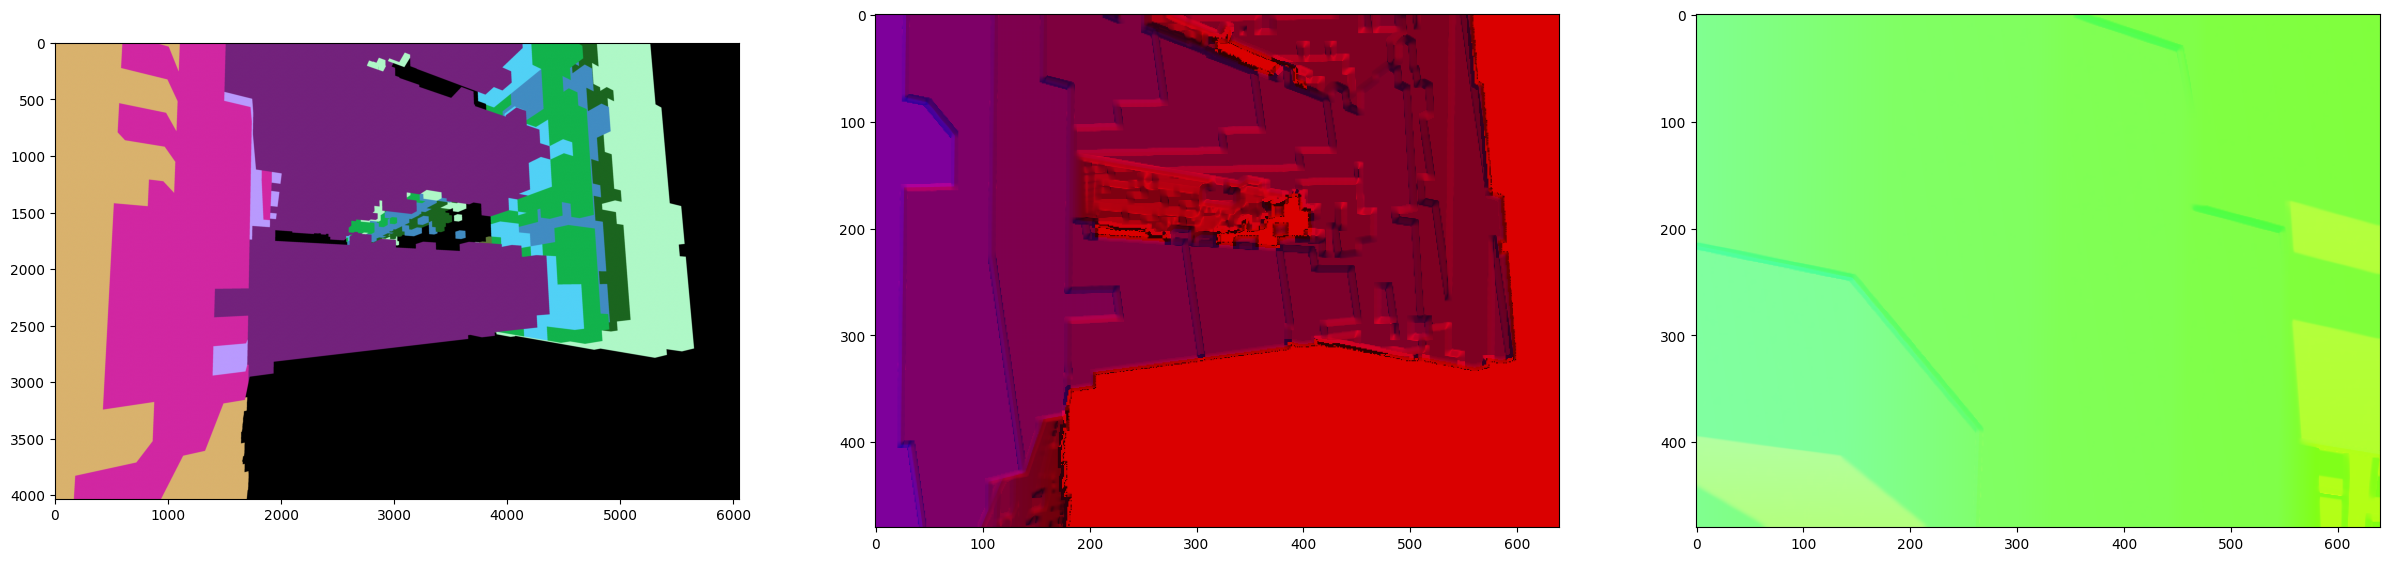

In [130]:
from matplotlib import pyplot as plt
import math
fig, axs = plt.subplots(1, 3,figsize=(30, 30))
fig.set_facecolor("white")
axs[0].imshow(test/255)
axs[1].imshow(hha_small2)
axs[2].imshow(hha_small3)
plt.show()

visualize the inputs

In [243]:
joinedImages=gmu.join_geometries([n.mesh for n in subNodes+otherNodes])
# o3d.visualization.draw_geometries([joinedImages]+[pcdNode.resource])

In [244]:
o3d.io.write_triangle_mesh('K:/Projects/2024-10 Project FWO Postdoc MB/7.Data/2023-01 Paestum/MESH/images.obj',joinedImages)

True

In [203]:
joinedImages=gmu.join_geometries(meshes)
joinedImages=joinedImages.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([joinedImages]+[pcdNode.resource])

colorize pcd per class

In [170]:
labels=las['labels']#las['02_Tecnica_costruttiva']
values=np.unique(labels)
pcd=copy.deepcopy(pcdNode.resource)
colors=np.array([ut.random_color() for v in range(len(values))])
colorArray=gmu.array_to_colors(labels,colors)
pcd.colors=o3d.utility.Vector3dVector(colorArray)

In [171]:
# optional
octree=pt.pcd_to_octree(pcd,8) #if octree is None else octree
mesh=gmu.octree_to_voxelmesh(octree) #if mesh is None else mesh

In [172]:
colorList=np.asarray(mesh.vertex_colors)
for i,c in enumerate(colors):
    # test1=
    # img=np.put(img,np.where(np.isclose(img,c,atol=0.01)),i)
    colorList=np.where(np.isclose(colorList,c,atol=0.01),i,colorList)
uniques,counts=np.unique(colorList,return_counts=True)
print(np.round(counts/np.sum(counts)*100,1))

[28.7  4.9 10.6 15.8  6.9  3.7  5.9  4.5 18.6  0.4]


In [207]:

o3d.visualization.draw_geometries([joinedImages]+[mesh])


(optional) Get depth and class labels image per image from the point cloud

In [ ]:
# colorImages1,depthImages1=pt.project_pcd_to_rgbd_images(pcd,myImageNodes,depth_max=30,fill_black=40)#
# for c,d,n in zip(colorImages1,depthImages1,imgNodes): 
#     n.mask1=pt.remap_color_images_to_masks(c,colors)[0]
#     n.colorImage1=c 
#     n.depthImage1=d 

Get depth and class labels image per image from the octree

In [32]:
octree=pt.pcd_to_octree(pcd,8) #if octree is None else octree
mesh=gmu.octree_to_voxelmesh(octree) #if mesh is None else mesh
# colorImages2,depthImages2=pt.project_meshes_to_rgbd_images(mesh, imgNodes) # no depth filtering currently
width=640
height=480
extrinsics=[n.cartesianTransform for n in imgNodes]
intrinsics=[np.array([[focalLength35mm/(n.imageWidth/width),0,width/2-0.5],[0,focalLength35mm/(n.imageHeight/height),height/2-0.5],[0,0,1]]) for n in imgNodes]
colorImages2,depthImages2=gmu.project_meshes_to_rgbd_images(mesh, extrinsics,intrinsics) # no depth filtering currently
for c,d,n in zip(colorImages2,depthImages2,imgNodes): 
    n.resource=iu.image_resize(n.resource,width=width,height=height)
    n.mask2=pt.remap_color_images_to_masks(c,colors)[0]
    n.colorImage2=c 
    n.depthImage2=d 
    n.hha=mlt.depth_map_to_hha(intrinsics[0],d,d) #! this takes 9min per image , perhaps scale it down and up
    
    # n.hha=mlt.depth_map_to_hha(n.get_intrinsic_camera_parameters().intrinsic_matrix,n.depthImage2,n.depthImage2) #! this takes 9min per image , perhaps scale it down and up

d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:157: RuntimeWarning: invalid value encountered in true_divide
  X_Z = np.divide(X, Z)
d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:158: RuntimeWarning: invalid value encountered in true_divide
  Y_Z = np.divide(Y, Z)
d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:162: RuntimeWarning: invalid value encountered in true_divide
  X_ZZ = np.expand_dims(np.divide(X, ZZ), axis=2)
d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:163: RuntimeWarning: invalid value encountered in true_divide
  Y_ZZ = np.expand_dims(np.divide(Y, ZZ), axis=2)
d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:184: RuntimeWarning: divide by zero encountered in true_divide
  b = np.divide(-detAtA, divide_fac)
d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:184: RuntimeWarnin

In [13]:
# subdivide images to 640,480
octree=pt.pcd_to_octree(pcd,8) #if octree is None else octree
mesh=gmu.octree_to_voxelmesh(octree) #if mesh is None else mesh
colorImages2,depthImages2=pt.project_meshes_to_rgbd_images(mesh, imgNodes) # no depth filtering currently
width=640
height=480
imgTrainingNodes=[]
for c,d,n in zip(colorImages2,depthImages2,imgNodes): 
    imgList,roiList=iu.subdivide_image(n.resource,m=3,n=3,includeLast=True) 
    imgList=[iu.image_resize(img, width=640,height=480) for img in imgList ]
#     n.resource=iu.image_resize(n.resource,width=width,height=height)
    masks,_=iu.subdivide_image(pt.remap_color_images_to_masks(c,colors)[0],m=3,n=3,includeLast=True) 
    masks=[iu.image_resize(img, width=640,height=480) for img in masks ]
    vizs,_=iu.subdivide_image(c ,m=3,n=3,includeLast=True) 
    vizs=[iu.image_resize(img, width=640,height=480) for img in vizs ]
    
    depths,_=iu.subdivide_image(d ,m=3,n=3,includeLast=True) 
    depths=[iu.image_resize(img, width=640,height=480) for img in depths ]
    
    hhas,_=iu.subdivide_image(mlt.depth_map_to_hha(n.get_intrinsic_camera_parameters().intrinsic_matrix,d,d),m=3,n=3,includeLast=True)  #! this takes 9min per image , perhaps scale it down and up
    hhas=[iu.image_resize(img, width=640,height=480) for img in hhas ]
    
    for img,roi,mask,viz,depth,hha in zip(imgList,roiList,masks,vizs,depths,hhas):
        imgTrainingNodes.append(ImageNode(resource=img,
                                isDerivedFrom=n.subject,
                                roi=roi,
                                mask=mask,
                                color=viz,
                                depth=depth,
                                hha=hha))  

d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:157: RuntimeWarning: invalid value encountered in true_divide
  X_Z = np.divide(X, Z)
d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:158: RuntimeWarning: invalid value encountered in true_divide
  Y_Z = np.divide(Y, Z)
d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:162: RuntimeWarning: invalid value encountered in true_divide
  X_ZZ = np.expand_dims(np.divide(X, ZZ), axis=2)
d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:163: RuntimeWarning: invalid value encountered in true_divide
  Y_ZZ = np.expand_dims(np.divide(Y, ZZ), axis=2)
d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:184: RuntimeWarning: divide by zero encountered in true_divide
  b = np.divide(-detAtA, divide_fac)
d:\Scan-to-BIM repository\geomapi\geomapi\tools\machinelearningtools\__init__.py:184: RuntimeWarnin

Visualize some results

In [39]:
from matplotlib import pyplot as plt
import math
n=imgNodes[random.randint(  0,len(imgNodes))]
fig, axs = plt.subplots(1, 3,figsize=(30, 30))
fig.set_facecolor("white")
axs[0].imshow(iu.image_resize(n.resource,scale=1/1))
axs[1].imshow(iu.image_resize(n.colorImage2,scale=1/1))
axs[2].imshow(iu.image_resize(n.hha,scale=1/1))
plt.show()

IndexError: list index out of range

(optional) write class labels to file.

In [15]:
import shutil

shutil.rmtree(dir_img) if os.path.exists(dir_img) else None 
os.mkdir(dir_img) if not os.path.exists(dir_img) else None 
shutil.rmtree(dir_class) if os.path.exists(dir_class) else None 
os.mkdir(dir_class) if not os.path.exists(dir_class) else None                      
shutil.rmtree(dir_depth) if os.path.exists(dir_depth) else None 
os.mkdir(dir_depth) if not os.path.exists(dir_depth) else None    
shutil.rmtree(dir_hha) if os.path.exists(dir_hha) else None 
os.mkdir(dir_hha) if not os.path.exists(dir_hha) else None    
shutil.rmtree(dir_labels) if os.path.exists(dir_labels) else None 
os.mkdir(dir_labels) if not os.path.exists(dir_labels) else None  

In [22]:
for n in imgTrainingNodes:
    n.color=np.round(n.color*255,0) 

In [23]:
train_list = []
test_list = []

for i,n in enumerate(imgTrainingNodes):
    #save image
    cv2.imwrite(os.path.join(dir_img,n.name+'.png'), n.resource)
    #class image
    # classImg=iu.grb01_to_rgb255(n.colorImage2)
    cv2.imwrite(os.path.join(dir_class,n.name+'.png'), n.color)
    #depth
    cv2.imwrite(os.path.join(dir_depth,n.name+'.png'), n.depth)
    #hha
    cv2.imwrite(os.path.join(dir_hha,n.name+'.png'), n.hha)  
    #labels
    cv2.imwrite(os.path.join(dir_labels,n.name+'.png'), n.mask)

    if i%2 ==0:
        train_list.append(n.name)
    else:
        test_list.append(n.name)

def write_txt(path_list, names):
    with open(path_list, 'w') as f:
        [f.write(name+'\n') for name in names]

path_list = os.path.join(output_dir, 'train.txt')
write_txt(path_list, train_list)

path_list = os.path.join(output_dir, 'test.txt')
write_txt(path_list, test_list)

In [158]:
files=ut.get_list_of_files("K:/Projects/2024-10 Project FWO Postdoc MB/7.Data/2023-01 Paestum/Research/shapeConv/image")
train_list = []
test_list = []
for i,f in enumerate(files):
    name=ut.get_filename(f)+'.JPG'
    print(name)
    if i%2 ==0:
        train_list.append(name)
    else:
        test_list.append(name)

def write_txt(path_list, names):
    with open(path_list, 'w') as f:
        [f.write(name+'\n') for name in names]

path_list = os.path.join('K:/Projects/2024-10 Project FWO Postdoc MB/7.Data/2023-01 Paestum/Research/shapeConv', 'train.txt')
write_txt(path_list, train_list)

path_list = os.path.join('K:/Projects/2024-10 Project FWO Postdoc MB/7.Data/2023-01 Paestum/Research/shapeConv', 'test.txt')
write_txt(path_list, test_list)

DSC_4226.JPG
DSC_4227.JPG
DSC_4228.JPG
DSC_4229.JPG
DSC_4230.JPG
DSC_4231.JPG
DSC_4232.JPG
DSC_4233.JPG
DSC_4234.JPG
DSC_4235.JPG
DSC_4236.JPG
DSC_4237.JPG
DSC_4238.JPG
DSC_4239.JPG
DSC_4240.JPG
DSC_4242.JPG
DSC_4243.JPG
DSC_4244.JPG
DSC_4245.JPG
DSC_4246.JPG
DSC_4247.JPG
DSC_4248.JPG
DSC_4249.JPG
DSC_4250.JPG
DSC_4251.JPG
DSC_4252.JPG
DSC_4253.JPG
DSC_4254.JPG
DSC_4255.JPG
DSC_4256.JPG
DSC_4257.JPG
DSC_4258.JPG
DSC_4259.JPG
DSC_4260.JPG
DSC_4261.JPG
DSC_4262.JPG
DSC_4263.JPG
DSC_4264.JPG
DSC_4265.JPG
DSC_4266.JPG
DSC_4267.JPG
DSC_4268.JPG
DSC_4269.JPG
DSC_4270.JPG
DSC_4271.JPG
DSC_4272.JPG
DSC_4273.JPG
DSC_4274.JPG
DSC_4275.JPG
DSC_4276.JPG
DSC_4277.JPG
DSC_4278.JPG
DSC_4279.JPG
DSC_4280.JPG
DSC_4281.JPG
DSC_4282.JPG
DSC_4283.JPG
DSC_4284.JPG
DSC_4285.JPG
DSC_4286.JPG
DSC_4287.JPG
DSC_4288.JPG
DSC_4289.JPG
DSC_4290.JPG
DSC_4291.JPG
DSC_4292.JPG
DSC_4293.JPG
DSC_4294.JPG
DSC_4295.JPG
DSC_4296.JPG
DSC_4297.JPG
DSC_4298.JPG
DSC_4299.JPG
DSC_4300.JPG
DSC_4301.JPG
DSC_4302.JPG
DSC_4303.JPG

In [141]:
files=ut.get_list_of_files("K:/Projects/2024-10 Project FWO Postdoc MB/7.Data/2023-01 Paestum/Research3/shapeConv/image")
for i,f in enumerate(files):
    img = cv2.imread(f)
    name=ut.get_filename(f)
    cv2.imwrite(os.path.join("K:/Projects/2024-10 Project FWO Postdoc MB/7.Data/2023-01 Paestum/Research3/shapeConv/image",f'{name}.JPG.png'),img)
    print(name)

DSC_4226
DSC_4227
DSC_4228
DSC_4229
DSC_4230
DSC_4231
DSC_4232
DSC_4233
DSC_4234
DSC_4235
DSC_4236
DSC_4237
DSC_4238
DSC_4239
DSC_4240
DSC_4242
DSC_4243
DSC_4244
DSC_4245
DSC_4246
DSC_4247
DSC_4248
DSC_4249
DSC_4250
DSC_4251
DSC_4252
DSC_4253
DSC_4254
DSC_4255
DSC_4256
DSC_4257
DSC_4258
DSC_4259
DSC_4260
DSC_4261
DSC_4262
DSC_4263
DSC_4264
DSC_4265
DSC_4266
DSC_4267
DSC_4268
DSC_4269
DSC_4270
DSC_4271
DSC_4272
DSC_4273
DSC_4274
DSC_4275
DSC_4276
DSC_4277
DSC_4278
DSC_4279
DSC_4280
DSC_4281
DSC_4282
DSC_4283
DSC_4284
DSC_4285
DSC_4286
DSC_4287
DSC_4288
DSC_4289
DSC_4290
DSC_4291
DSC_4292
DSC_4293
DSC_4294
DSC_4295
DSC_4296
DSC_4297
DSC_4298
DSC_4299
DSC_4300
DSC_4301
DSC_4302
DSC_4303
DSC_4304
DSC_4305
DSC_4306
DSC_4307
DSC_4308
DSC_4309
DSC_4310
DSC_4311
DSC_4312
DSC_4313
DSC_4314
DSC_4315
DSC_4316
DSC_4317
DSC_4318
DSC_4319
DSC_4320
DSC_4321
DSC_4322
DSC_4323
DSC_4324
DSC_4325
DSC_4326
DSC_4327
DSC_4328
DSC_4329
DSC_4330
DSC_4331
DSC_4332
DSC_4333
DSC_4334
DSC_4335
DSC_4336
DSC_4337
D

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [58]:
path='D:/Data/2023-01 NYU_v2/nyu_v2/depth'
import glob
test1 = cv2.imread('D:/Data/2023-01 Paestum/Research/shapeConv/depth/IMG_0609.png',cv2.IMREAD_GRAYSCALE)
print(test1.max())

test2 = cv2.imread('D:/Data/2023-01 NYU_v2/nyu_v2/depth/000117.png',cv2.IMREAD_GRAYSCALE)
print(test2.max())
# depth is different. we have inf and they have 14


59
38
